In [123]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, classification_report

torch.manual_seed(42)
np.random.seed(42)

In [124]:
def load_images(filename):
    with gzip.open(filename, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(num_images, rows, cols)
        return data

def load_labels(filename):
    with gzip.open(filename, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels


In [125]:
train_images = load_images("data/test/t10k-images-idx3-ubyte.gz")
train_labels = load_labels("data/test/t10k-labels-idx1-ubyte.gz")

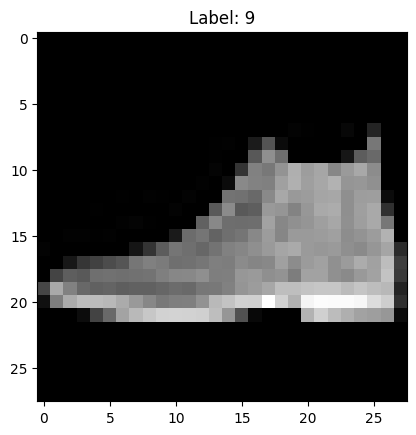

In [126]:
i = 0  # change index to view different images
plt.imshow(train_images[i], cmap='gray')
plt.title(f"Label: {train_labels[i]}")
plt.show()

In [127]:
class FashionDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32) / 255.0
        image = torch.tensor(image).view(-1)
        label = torch.tensor(self.labels[idx]).long()
        return image, label

dataset = FashionDataset(train_images, train_labels)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Train size: {len(train_dataset)}, Test size: {len(test_dataset)}')

Train size: 7000, Test size: 3000


In [128]:
class FashionNN(nn.Module):
    def __init__(self, input_size=784,hidden_size=512, hidden_size1=252, hidden_size2=128,hidden_size3=64, output_size=10):
        super (FashionNN, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, output_size)
        )

    def forward(self, x):
        return self.model(x)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionNN().to(device)

print(model)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters: {total_params}')

FashionNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=252, bias=True)
    (3): ReLU()
    (4): Linear(in_features=252, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)
Total trainable parameters: 572486


In [129]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [130]:
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/30], Loss: 1.0826
Epoch [2/30], Loss: 0.6522
Epoch [3/30], Loss: 0.5461
Epoch [4/30], Loss: 0.4992
Epoch [5/30], Loss: 0.4667
Epoch [6/30], Loss: 0.4360
Epoch [7/30], Loss: 0.3917
Epoch [8/30], Loss: 0.3829
Epoch [9/30], Loss: 0.3576
Epoch [10/30], Loss: 0.3456
Epoch [11/30], Loss: 0.3340
Epoch [12/30], Loss: 0.3101
Epoch [13/30], Loss: 0.3110
Epoch [14/30], Loss: 0.2885
Epoch [15/30], Loss: 0.2724
Epoch [16/30], Loss: 0.2711
Epoch [17/30], Loss: 0.2554
Epoch [18/30], Loss: 0.2592
Epoch [19/30], Loss: 0.2294
Epoch [20/30], Loss: 0.2318
Epoch [21/30], Loss: 0.2188
Epoch [22/30], Loss: 0.2246
Epoch [23/30], Loss: 0.2115
Epoch [24/30], Loss: 0.1948
Epoch [25/30], Loss: 0.1864
Epoch [26/30], Loss: 0.1907
Epoch [27/30], Loss: 0.1564
Epoch [28/30], Loss: 0.1642
Epoch [29/30], Loss: 0.1830
Epoch [30/30], Loss: 0.1535


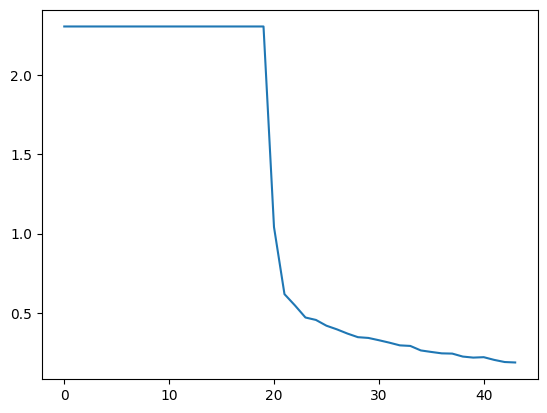

In [131]:
plt.plot(loss_history)

In [132]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 85.30%


              precision    recall  f1-score   support

           0       0.77      0.83      0.80       290
           1       0.96      0.98      0.97       279
           2       0.76      0.76      0.76       318
           3       0.90      0.86      0.88       315
           4       0.75      0.78      0.77       292
           5       0.95      0.87      0.91       297
           6       0.68      0.64      0.66       305
           7       0.89      0.94      0.91       301
           8       0.97      0.94      0.96       309
           9       0.91      0.94      0.92       294

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



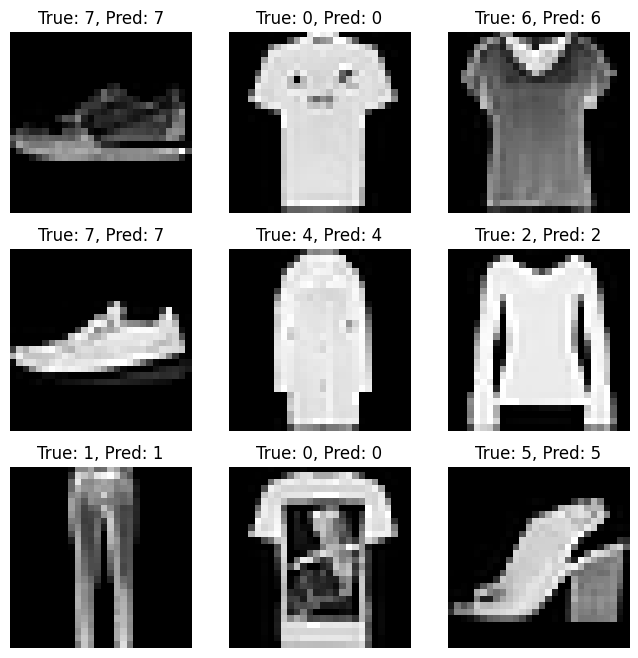

In [133]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = test_dataset[i]
    image = image.to(device).unsqueeze(0)
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    ax.imshow(image.cpu().view(28, 28), cmap='gray')
    ax.set_title(f'True: {label}, Pred: {predicted.item()}')
    ax.axis('off')
print(classification_report(all_labels, all_preds))
plt.show()